In [1]:
 # !apt-get install unzip
# !unzip .zip -d /content/dataset

In [2]:
# Локальный код обучения

import os.path as path
import os
import pickle
from enum import Enum
from typing import NoReturn, Optional
from tqdm import tqdm
import random
from pprint import pprint
import pandas as pd
import numpy as np
import time

import librosa
import librosa.feature as audio_F

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as nn_F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchaudio
import torchaudio.transforms as T

from transformers import ASTFeatureExtractor
from transformers import AutoModelForAudioClassification

import matplotlib.pyplot as plt

from IPython.display import Audio

import warnings
warnings.filterwarnings('ignore')


# feature extraction parameters
sample_rate = 32000
n_fft = 1024
overlap = 4
hop_length = n_fft // overlap
n_mels = 64

device = device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'{device=}')

cpu_count = os.cpu_count()
num_workers = cpu_count if device == "cpu" else 0
print(f'{num_workers=}, {cpu_count=}')


def set_random_state(random_state:int=0) -> NoReturn:
    """Initialize random generators.

    Parameters
    ==========
    random_state : int = 0
        Determines random number generation for centroid initialization.
        Use an int to make the randomness deterministic.
    """
    torch.manual_seed(random_state)
    random.seed(random_state)
    np.random.seed(random_state)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(random_state)
        torch.cuda.manual_seed(random_state)

        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    return

random_state = 42
set_random_state(random_state)
torch.use_deterministic_algorithms(True)

%env CUBLAS_WORKSPACE_CONFIG=:4096:8
%env PYTHONHASHSEED=42

base_folder = "./data"

# path
train_folder = path.join(base_folder, "train")
test_folder = path.join(base_folder, "test")
train_csv = path.join(base_folder, "train.csv")
train_pickle = path.join(base_folder, "train.pickle")
test_pickle = path.join(base_folder, "test.pickle")
labels_pickle = path.join(base_folder, "labels.pickle")

class SetType(Enum):
    """Set type"""
    TRAIN = 1
    TEST  = 2
    DEV   = 3


def extract_log_mel_feats(set_type:SetType, path_to_csv:str, path_to_files:str,
                          out_path:str, labels_pickle:str, sr:Optional[int], n_fft:int,
                          hop_length:int, n_mels:int):
    """
    Extract features from given files and store them in binary format.

    :param set_type: set tyle
    :param path_to_csv: path to loaded csv
    :param path_to_files: path to loaded data
    :param out_path: path to store extracted features
    :param labels_pickle: path to store labels dictionary
    :param sr: input files sample rate
    :param n_fft: size of fft window
    :param hop_length: hop size
    :param n_mels: number of mel band

    :return:
    """
    
    feature_extractor = ASTFeatureExtractor(sampling_rate=sr)
    
    if set_type not in [SetType.TRAIN, SetType.TEST]:
        raise Exception(f'Such set type not supported: {set_type}')

    feats = []

    if set_type == SetType.TRAIN:
        meta = pd.read_csv(path_to_csv, skiprows=1, names=['fname', 'label'])

        file_names = list(meta['fname'])
        n_files = len(file_names)
        labels = list(meta['label'])

        uniq_labels = np.sort(np.unique(labels))
        label_to_id = {label: i for i, label in enumerate(uniq_labels)}

        print('Total files:', n_files)

        for i, (file_name, label) in tqdm(enumerate(zip(file_names, labels))):
            wav_data, sr = librosa.load(os.path.join(path_to_files, file_name), sr=sr)
            f_ = feature_extractor(wav_data.squeeze(), sampling_rate=sample_rate, padding="max_length", return_tensors="pt")
            log_mel_spec = f_.input_values
            feats.append({
                'fname': file_name,
                'feature': log_mel_spec,
                'label_id': label_to_id[label]
            })

        pickle.dump(feats, open(out_path, 'wb'))
        pickle.dump(label_to_id, open(labels_pickle, 'wb'))
        return label_to_id
    else:
        for i, file_name in tqdm(enumerate(os.listdir(path_to_files))):
            wav_data, sr = librosa.load(os.path.join(path_to_files, file_name), sr=sr)
            if len(wav_data) == 0:
                wav_data = np.zeros(sr)
            f_ = feature_extractor(wav_data.squeeze(), sampling_rate=sample_rate, padding="max_length", return_tensors="pt")
            log_mel_spec = f_.input_values
            feats.append({
                'fname': file_name,
                'feature': log_mel_spec,
            })

        pickle.dump(feats, open(out_path, 'wb'))
        return


# extract features and store to `train_pickle` extracted features
label_to_id = extract_log_mel_feats(
    SetType.TRAIN,
    train_csv, 
    train_folder, 
    train_pickle,
    labels_pickle,
    sample_rate, 
    n_fft, 
    hop_length, 
    n_mels
)


extract_log_mel_feats(
    SetType.TEST, 
    '', 
    test_folder, 
    test_pickle, 
    '', 
    sample_rate, 
    n_fft, 
    hop_length, 
    n_mels
)


id_to_label = [label for label, i in label_to_id.items()]

In [3]:
#!pip install transformers
# !pip install torchsampler

In [4]:
# TODO: 
# 1. Add Imbalanced Dataset Sampler
# 2. Add convolution layer for classification

In [1]:
import os.path as path
import os
import pickle
from enum import Enum
from typing import NoReturn, Optional
from tqdm import tqdm
import random
from pprint import pprint
import pandas as pd
import numpy as np
import time

import librosa
import librosa.feature as audio_F

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as nn_F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchaudio
import torchaudio.transforms as T

from torchsampler import ImbalancedDatasetSampler

from transformers import ASTFeatureExtractor
from transformers import AutoModelForAudioClassification, ASTModel

import matplotlib.pyplot as plt

from IPython.display import Audio

import warnings
import random
warnings.filterwarnings('ignore')


In [2]:
# feature extraction parameters
sample_rate = 16_000
n_fft = 1024
overlap = 4
hop_length = n_fft // overlap
n_mels = 64

device = device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'{device=}')

cpu_count = os.cpu_count()
num_workers = cpu_count if device == "cpu" else 0
print(f'{num_workers=}, {cpu_count=}')

def set_random_state(random_state:int=0) -> NoReturn:
    """Initialize random generators.

    Parameters
    ==========
    random_state : int = 0
        Determines random number generation for centroid initialization.
        Use an int to make the randomness deterministic.
    """
    torch.manual_seed(random_state)
    random.seed(random_state)
    np.random.seed(random_state)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(random_state)
        torch.cuda.manual_seed(random_state)

        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    return

random_state = 42
set_random_state(random_state)
torch.use_deterministic_algorithms(True)



device='cuda'
num_workers=0, cpu_count=12


In [3]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8
%env PYTHONHASHSEED=42

env: CUBLAS_WORKSPACE_CONFIG=:4096:8
env: PYTHONHASHSEED=42


In [4]:
base_folder = "../../sambashare/ITMO_AED/ast_feat_extract/"

In [5]:
# path
train_csv = base_folder + "/train.csv"
train_pickle = base_folder + "/train.pickle"
test_pickle = base_folder + "/test.pickle"
labels_pickle = base_folder + "/labels.pickle"

In [6]:
class SetType(Enum):
    """Set type"""
    TRAIN = 1
    TEST  = 2
    DEV   = 3

class EventDetectionDataset(Dataset):
    def __init__(self, x, y=None, device="cpu", set_type=SetType.TRAIN):
        self.x = x
        self.y = y
        self.set_type = set_type

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # добавить сюда prepare_shape()
        # if self.set_type == SetType.TRAIN:
        # x = prepare_shape(self.x[idx])
        # else:
        # x = self.x[idx]
        x = self.x[idx]
        if self.set_type == SetType.TRAIN:
            stretch_factor = random.uniform(0.8, 1.2)
            mask_param = random.randint(10, 40)
            self.transforms = nn.Sequential(
                T.TimeStretch(stretch_factor, fixed_rate=True),
                T.FrequencyMasking(freq_mask_param=mask_param),
                T.TimeMasking(time_mask_param=mask_param)
               )
            x = self.transforms(x)
        if self.y is not None:
            x = torch.tensor(x, dtype=torch.float32, device=device).squeeze()
            y = torch.tensor(self.y[idx], dtype=torch.int, device=device)
            
            return x, y

        return torch.tensor(x, dtype=torch.float32, device=device).squeeze()
    
    def get_labels(self):
        return self.y

In [7]:
train_data = pickle.load(open(train_pickle, "rb"))
test_data = pickle.load(open(test_pickle, "rb"))

label_to_id = pickle.load(open(labels_pickle, "rb"))
id_to_label = [label for label, i in label_to_id.items()]

validation_set_size = 800
test_set_size = validation_set_size / len(train_data)


x_, y_ = [], []
for i, row in enumerate(train_data):
    feature = row['feature']
    x_.append(feature)
    y_.append(row['label_id'])

x_tr, x_val, y_tr, y_val = train_test_split(x_, y_, stratify=y_, test_size=test_set_size)

print(f"""
Train set:
    x.shape: {len(x_tr)}
    y.shape: {len(y_tr)}

Validation set:
    x.shape: {len(x_val)}
    y.shape: {len(y_val)}
    
Test set:
    x.shape: {len(test_data)}
    """)

train_dset = EventDetectionDataset(x_tr, y_tr, device=device, set_type=SetType.TRAIN)
val_dset = EventDetectionDataset(x_val, y_val, device=device, set_type=SetType.TEST)


Train set:
    x.shape: 4883
    y.shape: 4883

Validation set:
    x.shape: 800
    y.shape: 800
    
Test set:
    x.shape: 3790
    


In [8]:
torch.cuda.empty_cache()

In [9]:
train_loader = DataLoader(train_dset, 
                          sampler=ImbalancedDatasetSampler(train_dset), 
                          batch_size=10,
#                           shuffle=True, 
                          num_workers=num_workers, 
                          drop_last=True)
val_loader = DataLoader(val_dset, batch_size=10, shuffle=False, num_workers=num_workers, drop_last=True)

In [10]:
set_random_state(random_state)

sample_x, sample_y = random.choice(val_dset)

sample_y.item(), id_to_label[sample_y]

(26, 'Laughter')

In [11]:
set_random_state(random_state)

sample_x, sample_y = random.choice(train_dset)
sample_y.item(), id_to_label[sample_y]

(12, 'Double_bass')

In [12]:
# AutoModelForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.448")

In [13]:
# ast_model_ = ASTModel.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.448").to(device)

In [14]:
# ds_loader = DataLoader(train_dset, batch_size=1, shuffle=False, num_workers=num_workers, drop_last=False)
# for x in ds_loader:
#     out_ = ast_model_(x[0])
#     break

In [15]:
# x[0].shape

In [16]:
# ast_model_

In [17]:
# out_.last_hidden_state.shape

In [18]:
# out_.pooler_output.shape

In [19]:
# head = Head().to(device)
# # d = ast_model_(x[0].to(device))
# print(d[1].shape)
# len((head(torch.rand(1, 64, 768).to(device))[0]))

In [20]:
# m = AutoModelForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.448", num_labels=41, 
#                                                         ignore_mismatched_sizes=True)
# del m

In [21]:
# i = 0
# for n, param in m.audio_spectrogram_transformer.named_parameters():
#     print(n[0])

In [22]:
# class Head(nn.Module):
#     def __init__(self):
#         super(Head, self).__init__()
#         self.conv1 = nn.Conv1d(768, 300, 3, stride=1, padding=2)
#         self.conv2 = nn.Conv1d(300, 100, 3, stride=1, padding=2)
#         self.conv2_drop = nn.Dropout1d()
#         self.fc1 = nn.Linear(500, 41)

#     def forward(self, x):
#         x = x[:, :, None]
#         x = nn_F.relu(self.conv1(x), 2)
#         x = nn_F.relu(self.conv2_drop(self.conv2(x)), 2)
#         x = x.view(x.shape[0], -1)
#         x = self.fc1(x) #nn_F.relu(self.fc1(x))
# #         x = nn_F.dropout(x, training=self.training)
#         return nn_F.log_softmax(x, dim=1)

In [23]:
model = AutoModelForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.448", 
                                                        num_labels=len(id_to_label), 
                                                        ignore_mismatched_sizes=True)
model.config.id2label = id_to_label
model.config.label2id = label_to_id
model.config._num_labels = len(id_to_label)
model.config.num_labels = len(id_to_label)
# model.classifier = Head()
model.classifier = nn.Sequential(
    nn.Linear(in_features=768, out_features=len(id_to_label), bias=True)
)
# model.classifier = nn.Sequential(
#                         nn.Linear(in_features=768, out_features=300, bias=True),
#                         nn.ReLU(), 
#                         nn.Dropout(p=.25),
#                         nn.Linear(in_features=300, out_features=len(id_to_label), bias=True)
# )
# model.classifier = nn.Sequential(
#                         nn.Unflatten(1, (2, 5, 5)),
#                         nn.Conv1d(768, 64, 5),
#                         nn.MaxPool1d(2),
#                         nn.ReLU(),
#                         nn.Flatten(),
#                         nn.Linear(382, 41)
# )
model.requires_grad_(True)
# unfreeze
# flag = True
# for name, param in model.named_parameters():
#     if flag and 'layer.6' in name:
#         flag = False
#     if not flag: param.requires_grad = True
# model.classifier.requires_grad_(True)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.448 and are newly initialized because the shapes did not match:
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([41, 768]) in the model instantiated
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([41]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
model.classifier

Sequential(
  (0): Linear(in_features=768, out_features=41, bias=True)
)

In [25]:
model.num_labels, len(id_to_label)

(41, 41)

In [26]:
torch.cuda.empty_cache()

In [27]:
import copy

In [ ]:
start_time = time.time()

epochs = 100
train_loss = []
val_loss = []
train_f1 = []
val_f1 = []

f1_best = 0.87

for epoch in range(epochs):
    
    if epoch % 1 == 0:
        print(f'epoch #{epoch+1}')
    
    model.train()
    loss_list = []
    outs = []
    tgts = []
    
    for i_batch, sample_batched in enumerate(train_loader):
        
        inputs, labels = sample_batched
        outputs = model(inputs, labels=labels.long())
        loss = outputs.loss
        loss_list.append(loss.item())
        outs.append(outputs.logits.argmax(-1))
        tgts.append(labels)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    y_true = torch.hstack(tgts).numpy(force=True)
    y_pred = torch.hstack(outs).numpy(force=True)
    f1 = f1_score(y_true, y_pred, average='weighted')
    train_loss.append(np.mean(loss_list))
    train_f1.append(f1)
    if epoch % 1 == 0:
        print(f'[train] mean loss: {train_loss[-1]}')
        print(f'[train] f1-score:  {f1}')
    
    model.eval()
    loss_list = []
    outs = []
    tgts = []
    
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(val_loader):
            
            inputs, labels = sample_batched
            outputs = model(inputs, labels=labels.long())
            loss = outputs.loss
            loss_list.append(loss.item())
            outs.append(outputs.logits.argmax(-1))
            tgts.append(labels)
        
        y_true = torch.hstack(tgts).numpy(force=True)
        y_pred = torch.hstack(outs).numpy(force=True)
        f1 = f1_score(y_true, y_pred, average='weighted')
        if f1 > f1_best:
            f1_best = f1
            best_model = copy.deepcopy(model)
        val_loss.append(np.mean(loss_list))
        val_f1.append(f1)
        if epoch % 1 == 0:
            print(f'[val] mean loss:   {val_loss[-1]}')
            print(f'[val] f1-score:    {f1}', end="\n\n")
        

print(f"Execution time: {(time.time() - start_time):.2f} seconds")

epoch #1
[train] mean loss: 1.1059808426490816
[train] f1-score:  0.7445337300865629
[val] mean loss:   0.7317519828677177
[val] f1-score:    0.808436265778727

epoch #2
[train] mean loss: 0.3514275591034198
[train] f1-score:  0.9132102298043714
[val] mean loss:   0.5874171735718846
[val] f1-score:    0.8352234064167735

epoch #3
[train] mean loss: 0.1873014755756976
[train] f1-score:  0.9581440661060173
[val] mean loss:   0.603033690690063
[val] f1-score:    0.8508425595504582

epoch #4
[train] mean loss: 0.14341885357671494
[train] f1-score:  0.9644935281125739
[val] mean loss:   0.5351312459795736
[val] f1-score:    0.8616561418795143

epoch #5
[train] mean loss: 0.08515805187520617
[train] f1-score:  0.9801314929378708
[val] mean loss:   0.5457296526175923
[val] f1-score:    0.863958020612656

epoch #6
[train] mean loss: 0.08693115626457987
[train] f1-score:  0.9768466622264692
[val] mean loss:   0.6301350879948586
[val] f1-score:    0.8412557953933195

epoch #7
[train] mean loss: 

In [ ]:
def plot_validation_curve(epochs):
    
    epochs_ = range(1, epochs+1)

    fig, (ax_top, ax_bottom) = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=True)

    xticks = range(1, epochs+1, epochs // 10) if epochs > 10 else epochs_

    # draw loss
    ax_top.plot(epochs_, train_loss, 'r', label='train')
    ax_top.plot(epochs_, val_loss, 'b', label='validation')

    ax_top.set(
        title='Loss',
        xlabel='Epoch number',
        ylabel='Loss value',
        ylim=[0, max(max(train_loss), max(val_loss)) + 1],
    )
    ax_top.legend(
        title="Выборка",
    )
    ax_top.grid()

    # draw accuracy
    ax_bottom.plot(epochs_, train_f1, 'r', label='train')
    ax_bottom.plot(epochs_, val_f1, 'b', label='validation')

    ax_bottom.set(
        title='F-score',
        xlabel='Epoch number',
        ylabel='F-score value',
        xticks=xticks,
        ylim=[0, 1],
    )
    ax_bottom.legend(
        title="Выборка",
    )
    ax_bottom.grid()

    fig.suptitle("Кривые обучения")

    plt.show()

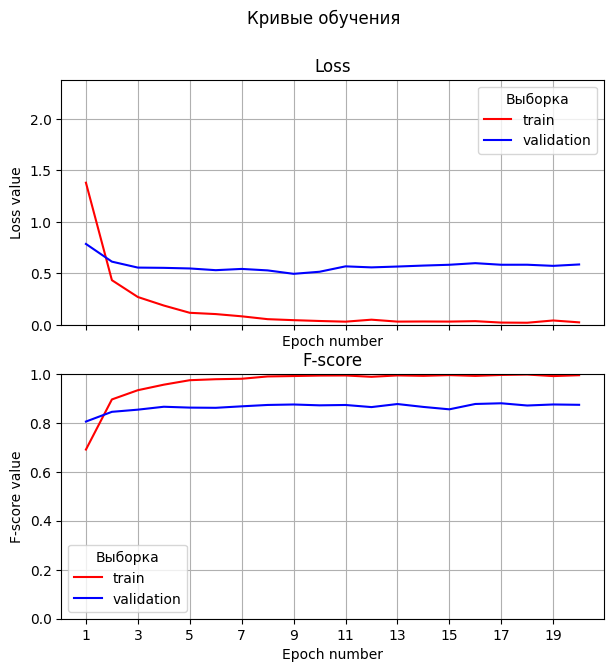

In [31]:
plot_validation_curve(epoch)

In [32]:
# l = nn.Linear(768, 41).to(device)
# d = model.audio_spectrogram_transformer(inputs).pooler_output
# print(d.shape, d[None, :].shape)
# print(l(d).shape)

In [33]:
# inputs[0].shape

In [34]:
#torch.save(model.state_dict(), 'model_weights_sr32k.pth')

In [35]:
# model = AutoModelForAudioClassification() # we do not specify pretrained=True, i.e. do not load default weights
# model.load_state_dict(torch.load('model_weights.pth'))
# model.eval()

In [36]:
# {id: label for id, label in enumerate(id_to_label)}

In [30]:
# model.config.id2label = {id: label for id, label in enumerate(id_to_label)}
# model.save_pretrained("model_weights_5", from_pt=True)
# model = AutoModelForAudioClassification.from_pretrained("model_weights")

In [29]:
torch.cuda.empty_cache()
# inference = AutoModelForAudioClassification.from_pretrained("model_weights_RNN")

outputs_infer = []
output_formated_infer = []

x_test = []
for i, row in enumerate(test_data):
    feature = row['feature']
    x_test.append(feature)
test_dset = EventDetectionDataset(x_test, None, device=device, set_type=SetType.TEST)
test_loader = DataLoader(test_dset, batch_size=32, shuffle=False, 
                         num_workers=num_workers, drop_last=False)


with torch.no_grad():
    for i_batch, sample_batched in enumerate(test_loader):
        x = sample_batched
        output_infer = best_model(x)
        outputs_infer.append(output_infer.logits.argmax(-1))
    output_formated_infer = torch.hstack(outputs_infer).numpy(force=True)

labled_outs = [id_to_label[i] for i in output_formated_infer]
fnames = []
for datum in test_data:
    fnames.append(datum['fname'])
pd.DataFrame({'fname': fnames, 'label': labled_outs}).to_csv('predict_11.csv', index=False)

In [42]:
# torch.cuda.empty_cache()
# # AutoModelForAudioClassification.from_pretrained("model_weights_4")

# outputs_infer = []
# output_formated_infer = []

# x_test = []
# for i, row in enumerate(test_data):
#     feature = row['feature']
#     x_test.append(feature)
# test_dset = EventDetectionDataset(x_test, None, device=device, set_type=SetType.TEST)
# test_loader = DataLoader(test_dset, batch_size=64, shuffle=False, 
#                          num_workers=num_workers, drop_last=False)


In [43]:
# inference.to(device)
# inference.eval()
# with torch.no_grad():
#   for i_batch, sample_batched in enumerate(test_loader):
#     x = sample_batched

#     output_infer = model(x)
#     outputs_infer.append(output_infer.logits.argmax(-1))
#   output_formated_infer = torch.hstack(outputs_infer).numpy(force=True)

In [44]:
# labled_outs = [id_to_label[i] for i in output_formated_infer]
# # print(labled_outs)

In [45]:
# fnames = []
# for datum in test_data:
#   fnames.append(datum['fname'])

In [46]:
# pd.DataFrame({'fname': fnames, 'label': labled_outs}).to_csv('predict_8.csv', index=False)

In [33]:
len(labled_outs)

3790

In [34]:
!pwd

/mnt/storage/kocharyan/test/AED


In [30]:
!cp predict_11.csv /mnt/storage/kocharyan/sambashare/

In [31]:
f1_best

0.8952672708933704

# Confusion Matrix

In [32]:
outputs_infer = []
output_formated_infer = []
with torch.no_grad():
    for i_batch, sample_batched in enumerate(DataLoader(val_dset, batch_size=16, shuffle=False, num_workers=num_workers)):
        x, y = sample_batched
        output_infer = best_model(x)
        outputs_infer.append(output_infer.logits.argmax(-1))
    output_formated_infer = torch.hstack(outputs_infer).numpy(force=True)

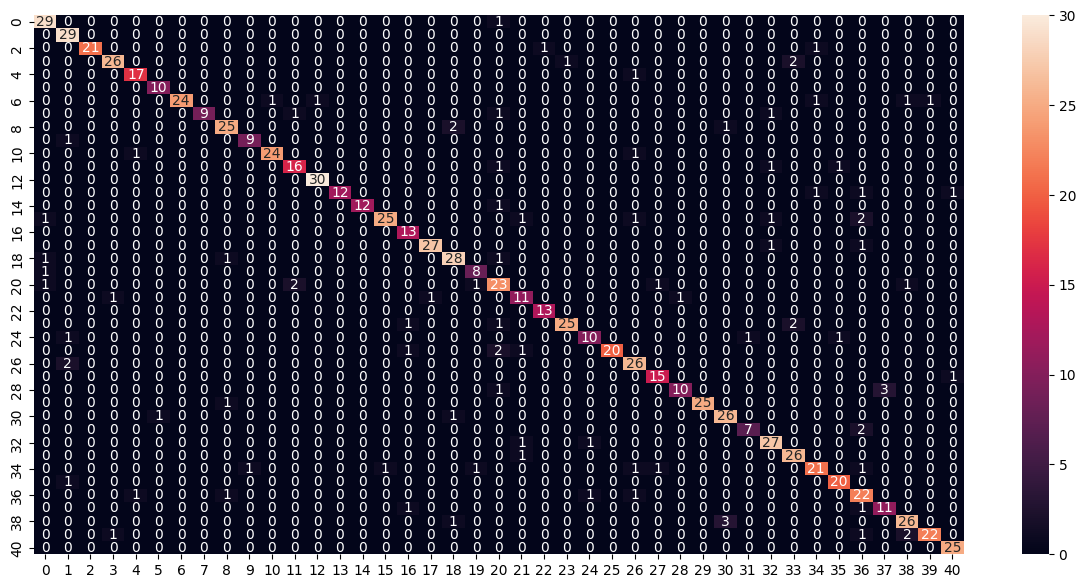

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(15, 7))
sns.heatmap(pd.DataFrame(confusion_matrix(y_val, output_formated_infer)), annot=True);

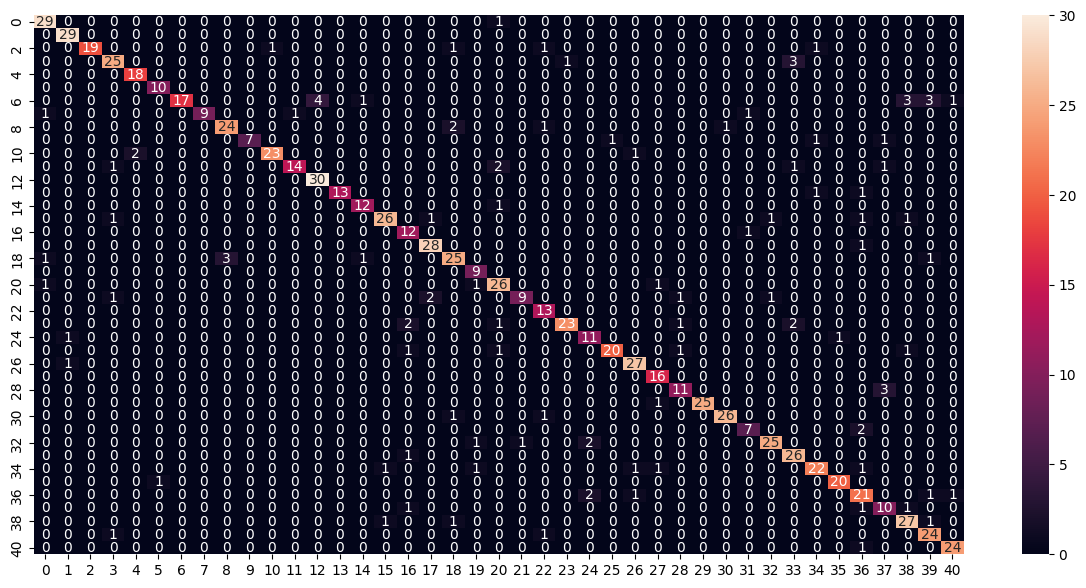

In [54]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(15, 7))
sns.heatmap(pd.DataFrame(confusion_matrix(y_val, output_formated_infer)), annot=True);

- Поиграться (в частности убрать) feature augmentation
- Убрать ImbalancerSampler
- Убрать тишину в начале/конце
- Использовать Fiass-KNN-классификацию/CatBoostClassification
- 

# Create new Dataset

In [87]:
import pickle
outputs_infer = []
output_formated_infer = []
with torch.no_grad():
    for i_batch, sample_batched in enumerate(DataLoader(train_dset, batch_size=1, shuffle=False, num_workers=num_workers)):
        x, y = sample_batched
        output_infer = best_model.audio_spectrogram_transformer(x).pooler_output
        outputs_infer.append(output_infer.numpy(force=True))
    output_formated_infer = np.concatenate(outputs_infer, axis=0)
pickle.dump(output_formated_infer, open('train_ast_infer.pkl', mode='wb'))
output_formated_infer.shape

(4782, 768)

In [85]:
import pickle
outputs_infer = []
output_formated_infer = []
with torch.no_grad():
    for i_batch, sample_batched in enumerate(DataLoader(val_dset, batch_size=1, shuffle=False, num_workers=num_workers)):
        x, y = sample_batched
        output_infer = best_model.audio_spectrogram_transformer(x).pooler_output
        outputs_infer.append(output_infer.numpy(force=True))
    output_formated_infer = np.concatenate(outputs_infer, axis=0)
pickle.dump(output_formated_infer, open('val_ast_infer.pkl', mode='wb'))
output_formated_infer.shape

(901, 768)

In [88]:
import pickle
outputs_infer = []
output_formated_infer = []
with torch.no_grad():
    for i_batch, sample_batched in enumerate(test_loader):
        x = sample_batched
        output_infer = best_model.audio_spectrogram_transformer(x).pooler_output
        outputs_infer.append(output_infer.numpy(force=True))
    output_formated_infer = np.concatenate(outputs_infer, axis=0)
pickle.dump(output_formated_infer, open('test_ast_infer.pkl', mode='wb'))
output_formated_infer.shape

(3790, 768)

In [91]:
X_train = pickle.load(open('train_ast_infer.pkl', mode='rb'))
X_val = pickle.load(open('val_ast_infer.pkl', mode='rb'))
X_test = pickle.load(open('test_ast_infer.pkl', mode='rb'))

In [109]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# clf = KNeighborsClassifier(metric='cosine').fit(X_train, y_tr)
clf = GaussianNB().fit(X_train, y_tr)

In [110]:
f1_score(y_val, clf.predict(X_val), average='weighted')

0.873871607796664

In [98]:
labled_outs = [id_to_label[i] for i in clf.predict(X_test)]
pd.DataFrame({'fname': fnames, 'label': labled_outs}).to_csv('predict_10.csv', index=False)

In [99]:
!cp predict_10.csv /mnt/storage/kocharyan/sambashare/

In [118]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier


estimators = [
    ('lr',  make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', random_state=42))),
    ('nb', make_pipeline(StandardScaler(), GaussianNB())), 
    ('knn', make_pipeline(StandardScaler(), KNeighborsClassifier(metric='cosine'))),
    ('knn_', make_pipeline(StandardScaler(), KNeighborsClassifier(metric='euclidean')))
]
clf = StackingClassifier(estimators=estimators, final_estimator=GradientBoostingClassifier())
clf.fit(X_train, y_tr)
f1_score(y_val, clf.predict(X_val), average='weighted')

0.8795936859252883